In [2]:
%cd tacotron2

/home/ec2-user/SageMaker/FakeVoice/tacotron2


In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import epitran
import eng_to_ipa as ipa
import re


from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from text.cleaners import english_cleaners
from utils import make_arpabet
from hparams import create_hparams

/home/ec2-user/SageMaker/FakeVoice/tacotron2/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/ec2-user/anac

In [4]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [5]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [18]:
checkpoint_path = "outdir/checkpoint_7000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [19]:
waveglow_path = 'waveglow/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

In [20]:
text = "Who lives in a pineapple under the. "

#epitran preprocessing loop
hparams = create_hparams()
epi = epitran.Epitran('eng-Latn', ligatures = True)
if hparams.preprocessing == "ipa":
  text = ipa.convert(english_cleaners(text))
  foreign_words = re.findall(r"[^ ]{0,}\*", text)
  for word in foreign_words:
    text = text.replace(word, epi.transliterate(word[0:len(word)-1]))
if hparams.preprocessing == "arpabet":
  text = make_arpabet(text)

print(text)


Who lives in a pineapple under the. 


In [21]:

#text sequencer
if hparams.preprocessing is not None:
  sequence = np.array(text_to_sequence(text, None))[None, :]
else:
  sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

Warning! Reached max decoder steps


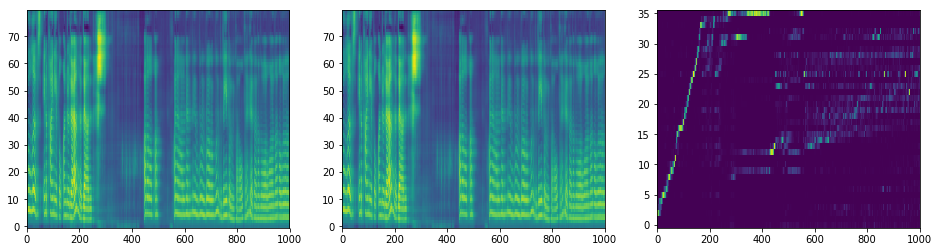

In [22]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

Warning! Reached max decoder steps


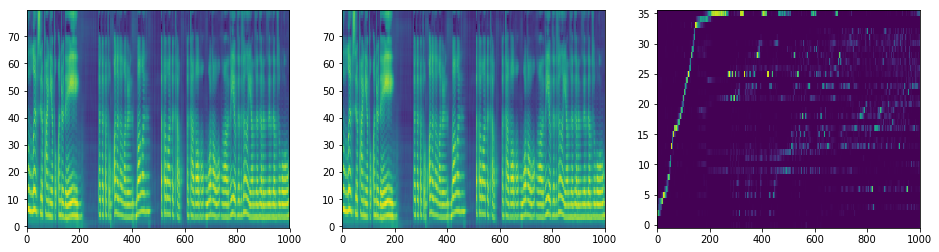

In [11]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [23]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [25]:
!nvidia-smi


Thu Dec  9 19:05:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   75C    P0    69W /  70W |  11557MiB / 15109MiB |     46%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        7.7G   80K  7.7G   1% /dev
tmpfs           7.7G   25M  7.7G   1% /dev/shm
/dev/nvme0n1p1  109G   98G   11G  91% /
/dev/nvme2n1     25G  7.7G   16G  33% /home/ec2-user/SageMaker
